In [182]:
import tensorflow as tf
import keras_tuner
import numpy as np


import pandas as pd
import openpyxl # Needed for reading excel
import pathlib

import decomposition
import models
import data
from metrics import smape
from windower import WindowGenerator
import hp_training
import results

In [205]:
cwd = pathlib.Path.cwd()

code_directory = cwd.parents[1]
gonem_directory = code_directory / "notebooks" / "Gonem"
model_directory = gonem_directory / 'models'

model = 'SS'
product = 'maize'
model_path =  model_directory / f"{model}_{product}_in_sample"
checkpoint_path = model_path / f"{model}_{product}"
results_path = model_directory / f"{model}_{product}_in_sample_SCENARIO_OILPRICESHOCK_[183, 48, 26, 90, 82]"


In [207]:
# df = data.get_data(directory_path=gonem_directory, product=product)
df = data.get_data(gonem_directory / "SCENARIO_OILPRICESHOCK_[183, 48, 26, 90, 82]_2023-03-10_02-56-23.xlsx")

df = df.iloc[:-2]
df.describe()

AVG_TAVG                                                  \
PARTNER_Labels      Brazil      France     Germany     Hungary     Ukraine   
count           212.000000  212.000000  212.000000  212.000000  212.000000   
mean            238.213467  125.120399  103.852255  116.129388   96.215727   
std              24.185228   55.581487   65.415460   79.506412   90.577074   
min             146.692308   20.168095  -29.860742  -50.419892  -98.247057   
25%             228.163849   76.846499   47.985468   42.248987   16.463480   
50%             246.068678  121.139616  101.023015  120.209032   91.978710   
75%             254.833821  177.800263  164.291849  191.053584  183.358356   
max             276.134483  231.747995  229.864177  242.571429  239.800437   

               Corn Price Futures    MAX_TMAX                          \
PARTNER_Labels             Global      Brazil      France     Germany   
count                  212.000000  212.000000  212.000000  212.000000   
mean                   447.205189  345.878032  225.155034  218.462006   
std                    150.596080   24.373066   67.282110   81.540537   
min                    201.750000  282.000000  107.622222   36.388889   
25%                    356.437500  330.875000  163.036330  140.056561   
50%                    389.625000  345.000000  227.637049  225.650735   
75%                    555.750000  360.625000  284.274194  287.716912   
max                    818.250000  401.000000  362.382979  371.823529   

                            ... renewable_energy_consumption_perc_of_total  \
PARTNER_Labels     Hungary  ...                                     Brazil   
count           212.000000  ...                                 212.000000   
mean            238.409827  ...                                  45.961321   
std              86.291146  ...                                   1.909219   
min              43.666667  ...                                  41.710000   
25%             162.625000  ...                                  44.839375   
50%             243.400000  ...                                  46.680417   
75%             317.125000  ...                                  47.570000   
max             392.500000  ...                                  48.920000   

                                                                \
PARTNER_Labels      France     Germany     Hungary     Ukraine   
count           212.000000  212.000000  212.000000  212.000000   
mean             12.858797   13.605825   13.299269    4.511203   
std               2.269171    2.843999    2.701251    2.124186   
min               8.520000    7.280000    7.290000    1.270000   
25%              11.130833   11.072292   12.753125    2.807500   
50%              13.277500   13.938750   13.640000    3.497917   
75%              15.270000   16.316875   15.388750    7.017500   
max              15.530000   17.170000   17.180000    7.440000   

               unemployment_total                                      \
PARTNER_Labels             Brazil      France     Germany     Hungary   
count                  212.000000  212.000000  212.000000  212.000000   
mean                    10.096958    8.980330    5.606981    7.008726   
std                      2.280336    0.864391    2.218326    2.706634   
min                      6.760000    7.390000    3.140000    3.420000   
25%                      8.174167    8.110625    3.664375    4.084583   
50%                      9.502083    9.101250    5.032083    7.355833   
75%                     12.416250    9.801875    7.435208    9.591042   
max                     13.700000   10.350000   11.170000   11.170000   

                            
PARTNER_Labels     Ukraine  
count           212.000000  
mean              8.350071  
std               1.099230  
min               6.350000  
25%               7.462500  
50%               8.503750  
75%               9.272500  
max               9.830000  

[8 rows x 63 columns]

In [208]:
label_columns = ['price']
label_columns = df.columns[df.columns.get_level_values(0).isin(label_columns)].tolist()
label_columns

[('price', 'Brazil'),
 ('price', 'France'),
 ('price', 'Germany'),
 ('price', 'Global'),
 ('price', 'Hungary'),
 ('price', 'Ukraine')]

In [209]:
stl = decomposition.STLDecomposer(labels=label_columns, period=12)
log = decomposition.Logger(labels=label_columns)
std = decomposition.Standardizer()

preproc = decomposition.Processor().add(stl).add(log).add(std)

In [210]:
width = 24
label_width = 6
shift = 6

window = WindowGenerator(input_width=width, label_width=label_width, shift=shift, data=df, 
                    # train_begin=0, train_end=.9, val_begin=None, val_end=.96,
                    train_begin=0, train_end=.97, val_begin=None, val_end=None,
                    # train_begin=0, train_end=.5, val_begin=None, val_end=.8,
                    test_begin=0., test_end=1., connect=True, remove_labels=True, label_columns=label_columns)
window.preprocess(preproc)
window

Total window size: 30
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29]
Label column name(s): [('price', 'Brazil'), ('price', 'France'), ('price', 'Germany'), ('price', 'Global'), ('price', 'Hungary'), ('price', 'Ukraine')]

In [211]:
label_std = decomposition.Standardizer(mean=std.mean[window.label_columns], std=std.std[window.label_columns])
label_log = decomposition.Logger(label_indices=range(len(window.label_columns)))
postproc = decomposition.Processor().add(label_std).add(label_log)
window.add_label_postprocess(postproc)

In [212]:
tuner = hp_training.get_tuner(model, gonem_directory/'hp', window)

INFO:tensorflow:Reloading Tuner from /code/notebooks/Gonem/hp/SS/tuner0.json


In [213]:
# hp_training.run(tuner, window)

In [214]:
best_hps = tuner.get_best_hyperparameters()[0]
best_hps.values

{'lstm_units': 416,
 'lstm_layers': 0,
 'dense_units': 416,
 'dense_layers': 0,
 'heads': 2,
 'dropout': 0.38972766578190643,
 'key_dim': 128,
 'l1': 0.0009215140300448076,
 'l2': 0.0002556079498371441,
 'learning_rate': 0.0012848169081952467,
 'tuner/epochs': 200,
 'tuner/initial_epoch': 67,
 'tuner/bracket': 3,
 'tuner/round': 3,
 'tuner/trial_id': '0203'}

In [202]:
hp_training.final_train(tuner, window, checkpoint_path)

Epoch 1/200



KeyboardInterrupt



In [215]:
m = tuner.hypermodel.build(best_hps)
m.load_weights(checkpoint_path)
m.evaluate(window.test)

6/6 [==============================] - 2s 50ms/step - loss: 88.1731 - mae: 0.4884 - mse: 0.6635 - mape: 1114.2953 - smape: 79.0456


[88.17308807373047,
 0.48841366171836853,
 0.663536787033081,
 1114.2952880859375,
 79.04560089111328]

('price', 'Brazil')


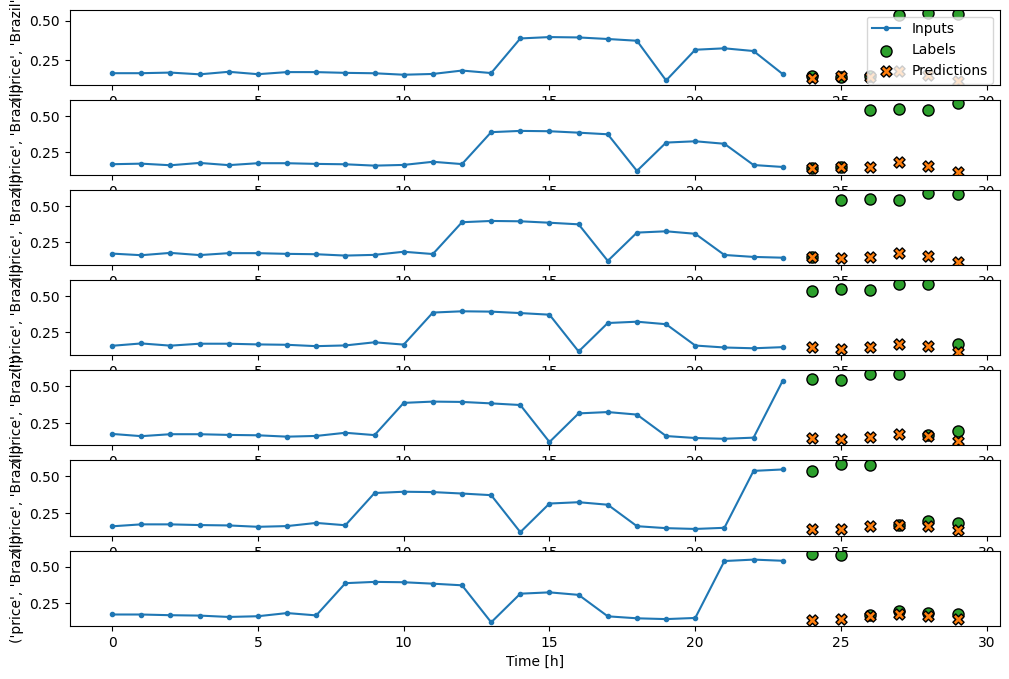

('price', 'France')


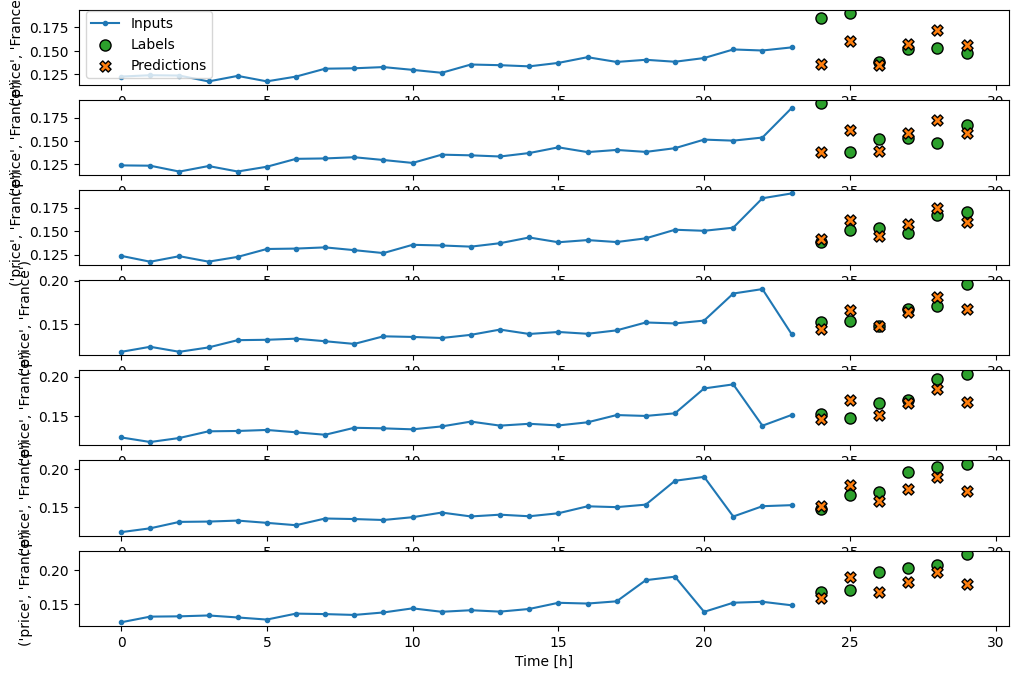

('price', 'Germany')


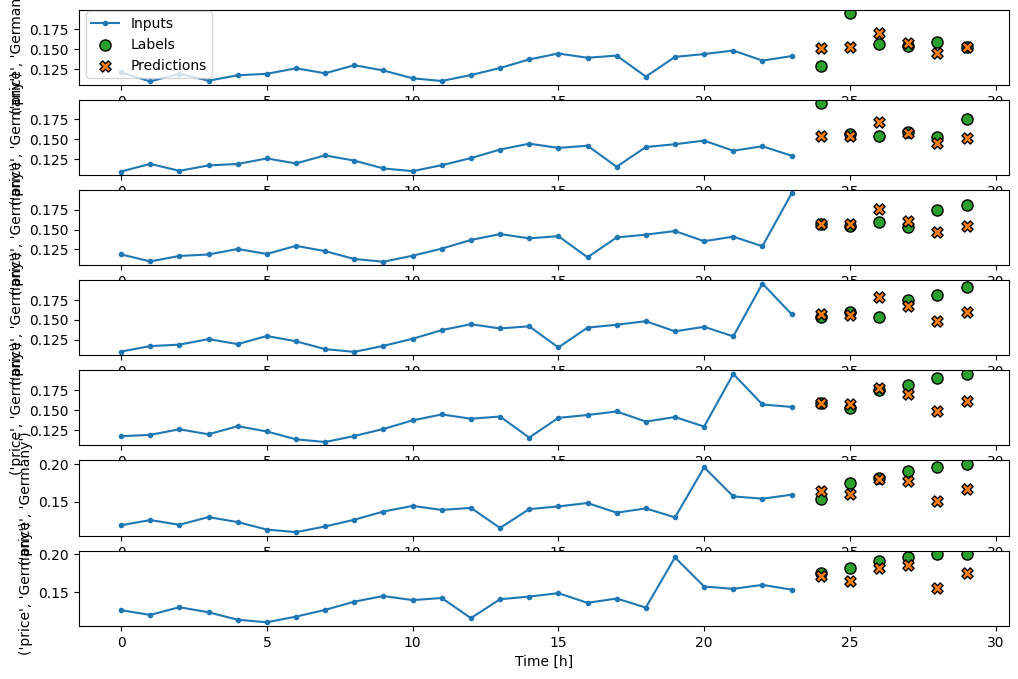

('price', 'Global')


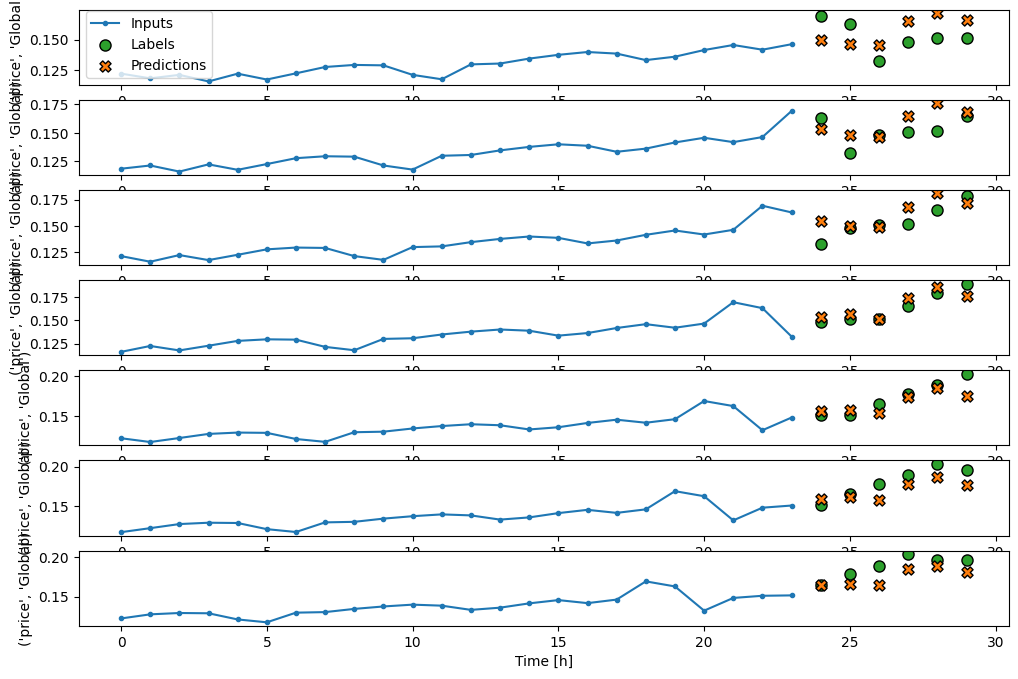

('price', 'Hungary')


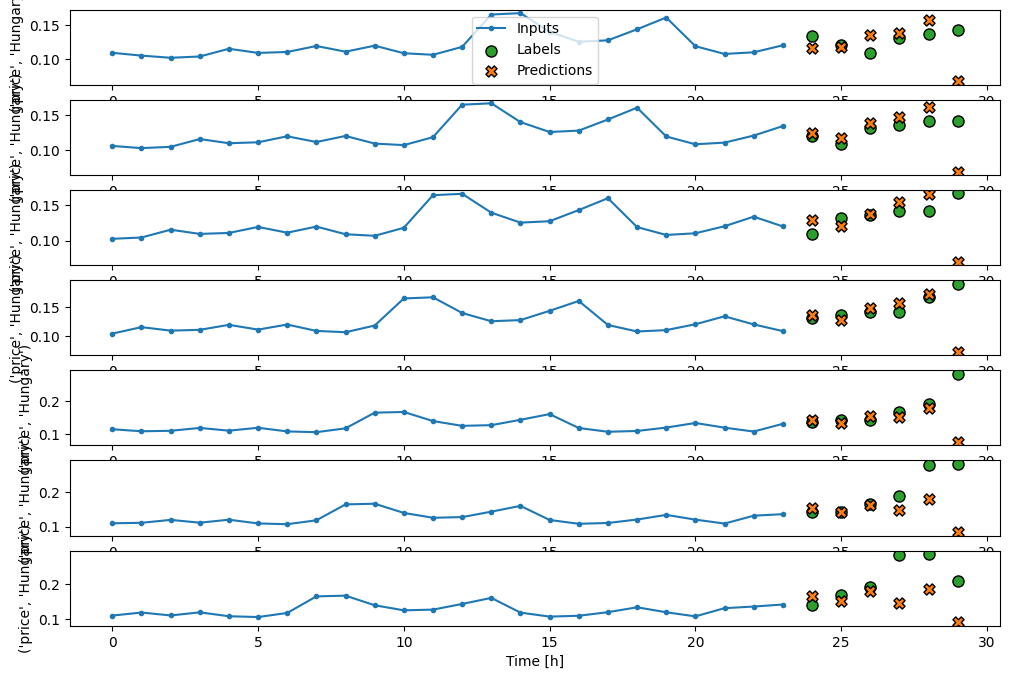

('price', 'Ukraine')


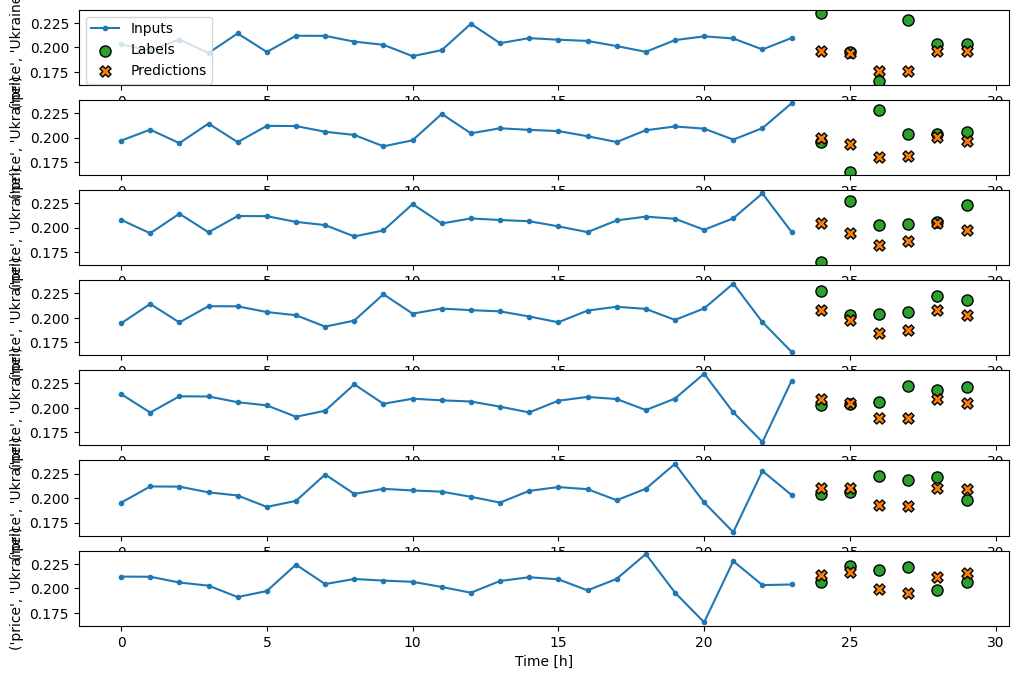

In [218]:
window.test

# val_performance['1'] = m.evaluate(w.val)
for i in range(6):

    label = label_columns[i]
    print(label)
    # performance['1'] = m.evaluate(w.test)
    window.plot(m, plot_col=label, max_subplots=7)


In [ ]:
inputs, labels, predictions, weights, mcds = [], [], [], [], []
for x, y in window.test.take(40):
    inputs.append(x)
    lab = y
    lab = window.label_postprocessor.reverse(lab)
    labels.append(lab)
    
    pred = m(x)
    pred = window.label_postprocessor.reverse(pred)
    predictions.append(pred)
    
    weight = m.attention_layer(x, return_weights=True)[1]
    weights.append(weight)
    
    mcd = results.monte_carlo_dropout(x, m, 100, window.label_postprocessor.reverse, return_weight=False)
    mcds.append(mcd)
    weights.append(weight)
    
inputs = tf.concat(inputs, axis=0)
labels = tf.concat(labels, axis=0)
weights = tf.concat(weights, axis=0)
weights = tf.reduce_mean(weights, axis=0)
predictions = tf.concat(predictions, axis=0)
mcds = tf.concat(mcds, axis=1)

In [ ]:
np.save(model_path / f"{product}_inputs_SCENARIO_OILPRICESHOCK_[183, 48, 26, 90, 82]", inputs.numpy())
np.save(model_path / f"{product}_labels_SCENARIO_OILPRICESHOCK_[183, 48, 26, 90, 82]", labels.numpy())
np.save(model_path / f"{product}_weights_SCENARIO_OILPRICESHOCK_[183, 48, 26, 90, 82]", weights.numpy())
np.save(model_path / f"{product}_predictions_SCENARIO_OILPRICESHOCK_[183, 48, 26, 90, 82]", predictions.numpy())
np.save(model_path / f"{product}_mcd_predictions_SCENARIO_OILPRICESHOCK_[183, 48, 26, 90, 82]", mcds.numpy())


In [100]:
predictions.shape

TensorShape([185, 6, 6])